# Import Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # specify which GPU(s) to be used
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from utilities.UAPS_net_factory import net_factory

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model

In [5]:
model = net_factory(net_type='unet_uaps', in_chns=3, class_num=2)

model = nn.DataParallel(model)

In [6]:
#Load model state dict
checkpoint_0 = torch.load(".../model_weights/KoSDD2/UAPS_KoSDD2_40p.pth")
print(checkpoint_0['epoch'])
#Loading the trained model weight
model.load_state_dict(checkpoint_0['state_dict'])

print('The state dics are loaded')
# print(checkpoint_0['best_loss_1'])

321
The state dics are loaded


# Metrics

In [7]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [8]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(1, n_classes): #loop per pixel class , start from class 1, excluding the background class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)

            # elif true_label.long().sum().item() > 0 and true_class.long().sum().item() ==0: #no exist label in this loop
            #     iou = 0
            #     iou_per_class.append(iou)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [9]:
def mDice(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        dice_per_class = []
        for clas in range(1, n_classes): #loop per pixel class, starting from the second class, excluding the background class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                dice_per_class.append(np.nan)

            # elif true_label.long().sum().item() > 0 and true_class.long().sum().item() ==0: #no exist label in this loop
            #     dice = 0
            #     dice_per_class.append(dice)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                dice = 2*(intersect + smooth) / (union + intersect +smooth)
                dice_per_class.append(dice)
        return np.nanmean(dice_per_class)

In [10]:

IMAGE_PATH = '.../data/KoSDD2/Test/Images/'
MASK_PATH = '.../data/KoSDD2/Test/Labels/'

n_classes = 2

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
X_test = df['id'].values
print('Total Images: ', len(X_test))

class NEUTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        mask = (mask/255.0).long()

        
        return img, mask


t_test = A.Resize(512, 256, interpolation=cv2.INTER_NEAREST)
test_set = NEUTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

Total Images:  110


## Result

In [11]:
kl_distance = nn.KLDivLoss(reduction='none') #KL_loss for consistency training
log_sm = torch.nn.LogSoftmax(dim = 1) #For computing the KL distance
sm = torch.nn.Softmax(dim = 1)
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0).permute(0,1,3,2)
        mask = mask.unsqueeze(0).permute(0,2,1)
                
        output, ax1, ax2, ax3 = model(image)
        var = kl_distance(log_sm(output), sm(ax3)) #To calculate the Uncertainity map between the prediction and the ground truth map.
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score, var

In [12]:
def predict_image_mask_mdice(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0).permute(0,1,3,2)
        mask = mask.unsqueeze(0).permute(0,2,1)
        
        output, ax1, ax2, ax3= model(image)
        score = mDice(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [13]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0).permute(0,1,3,2)
        mask = mask.unsqueeze(0).permute(0,2,1)
        
        output, ax1, ax2, ax3 = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [14]:
def miou_score(model, test_set):
    score_iou = []
        
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score, var = predict_image_mask_miou(model, img, mask) #Including the prediciton variance
        score_iou.append(score)
        # score_iou_0.append(iou_0)
        
    return score_iou

In [15]:
def mdice_score(model, test_set):
    score_dice = []
    
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_mdice(model, img, mask)
        score_dice.append(score)
        
    return score_dice

In [16]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [17]:
mob_mdice = mdice_score(model, test_set)

  0%|          | 0/110 [00:00<?, ?it/s]

In [18]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/110 [00:00<?, ?it/s]

In [19]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/110 [00:00<?, ?it/s]

In [20]:
#Decoding binary mask to color rgb
def decode_segmap(image, nc=2):
  
  label_colors = np.array([(0,0,0), (0,255,255)])

            # 0=background, # 1=Inclusions, 2=Patches, 3=Scratches
            #Sctrach = (128,128,0)
            #Patches = (0,128,0)
            # Inclusion = (128,0,0)
            #Red = (128,128,0)
            #                   (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
            #    (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
            #    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)]

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

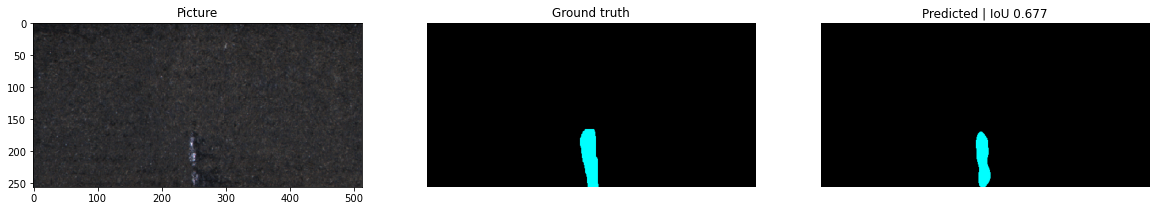

In [21]:
t_u = T.Compose([T.ToTensor()]) #For image transformation

image, mask = test_set[65]
pred_mask, score, var = predict_image_mask_miou(model, image, mask)

im = t_u(image) #Chaning to tesnor for plotting the input image

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
# ax1.imshow(image, cmap='gray')
ax1.imshow(im.permute(2,1,0))
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask.permute(1,0)))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask))
ax3.set_title('Predicted | IoU {:.3f}'.format(score))
ax3.set_axis_off()

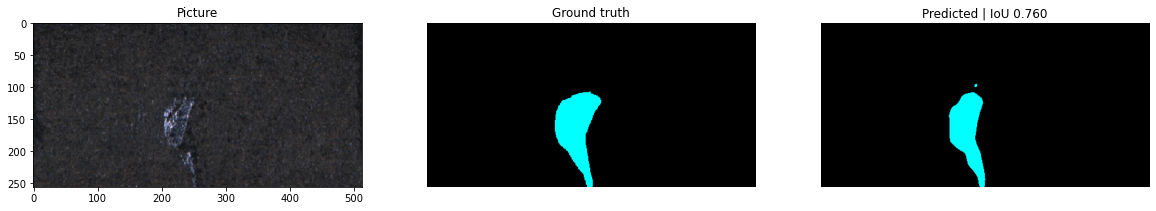

In [22]:
t_u = T.Compose([T.ToTensor()]) #For image transformation
image2, mask2 = test_set[11]

pred_mask2, score2, var = predict_image_mask_miou(model, image2, mask2)

im = t_u(image2) #Chaning to tesnor for plotting the input image


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
# ax1.imshow(image2, cmap='gray')
ax1.imshow(im.permute(2,1,0))
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask2.permute(1,0)))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask2))
ax3.set_title('Predicted | IoU {:.3f}'.format(score2))
ax3.set_axis_off()

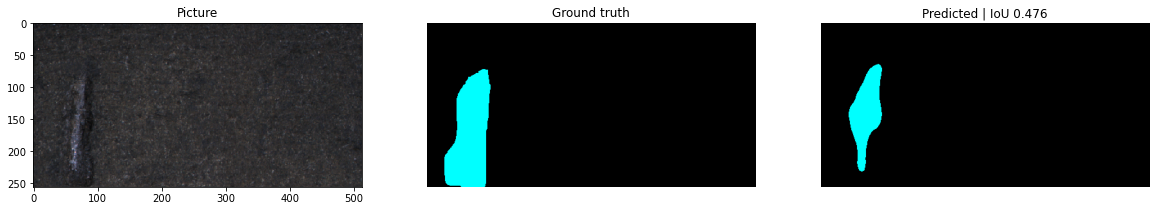

In [23]:
t_u = T.Compose([T.ToTensor()]) #For image transformation

image3, mask3 = test_set[42]
pred_mask3, score3, var = predict_image_mask_miou(model, image3, mask3)

im = t_u(image3) #Chaning to tesnor for plotting the input image

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(im.permute(2,1,0))
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask3.permute(1,0)))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask3))
ax3.set_title('Predicted | IoU {:.3f}'.format(score3))
ax3.set_axis_off()

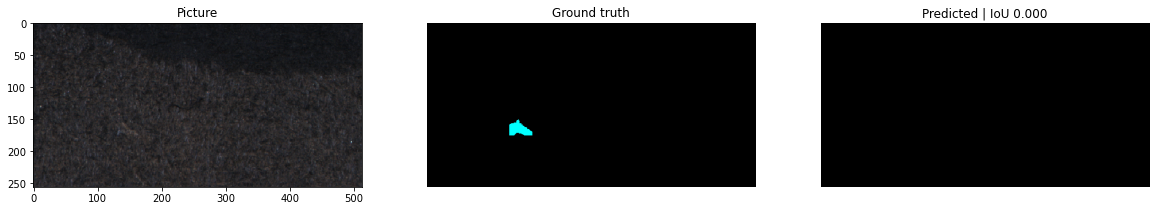

In [24]:
t_u = T.Compose([T.ToTensor()]) #For image transformation

image3, mask3 = test_set[0]
pred_mask3, score3, var = predict_image_mask_miou(model, image3, mask3)

im = t_u(image3) #Chaning to tesnor for plotting the input image

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(im.permute(2,1,0))
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask3.permute(1,0)))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask3))
ax3.set_title('Predicted | IoU {:.3f}'.format(score3))
ax3.set_axis_off()

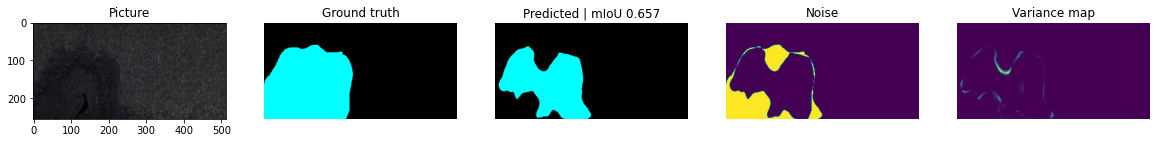

In [25]:
t_u = T.Compose([T.ToTensor()]) #For image transformation
image3, mask3 = test_set[98]
pred_mask3, score3, var = predict_image_mask_miou(model, image3, mask3)

im = t_u(image3) #Chaning to tesnor for plotting the input image

var = var.cpu().squeeze(0)
var1 = torch.sum(var, dim = 0)
uncertainity = mask3.permute(1,0) - pred_mask3
uncertainity[uncertainity>0] = 1
uncertainity[uncertainity<0] = 1

# confidence = 1 - var1
# uncertainity[uncertainity<=0] = 0

# var = torch.sum(kl_distance(pred_mask3, mask3), dim=1)
# var
# lbl_exp_variance_aux1 = torch.exp(-lbl_variance_aux1)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20,10))
ax1.imshow(im.permute(2,1,0))
ax1.set_title('Picture');

ax2.imshow(decode_segmap(mask3.permute(1,0)))
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(decode_segmap(pred_mask3))
ax3.set_title('Predicted | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

ax4.imshow(uncertainity)
ax4.set_title('Noise')
ax4.set_axis_off()

ax5.imshow(var1)
ax5.set_title('Variance map')
ax5.set_axis_off()



In [26]:
# import module
from tabulate import tabulate
 
# assign data
Results = [
    ["Score", np.mean(mob_miou)*100, np.mean(mob_mdice)*100, np.mean(mob_acc)*100] 
]
 
# create header
head = ["Metrics", "mIoU(%)", "mDice(%)", "Accuracy(%)"]
 
# display table
print(tabulate(Results, headers=head, tablefmt="fancy_grid"))

╒═══════════╤═══════════╤════════════╤═══════════════╕
│ Metrics   │   mIoU(%) │   mDice(%) │   Accuracy(%) │
╞═══════════╪═══════════╪════════════╪═══════════════╡
│ Score     │   52.7175 │     62.991 │       98.5936 │
╘═══════════╧═══════════╧════════════╧═══════════════╛
